# About `ImageDataGenerator`

This post gives a few comments on how to use `ImageDataGenerator` for testing a model in Keras.


I have been working on the Chapter 5 of *Deep Learning with Python*. However, I had some issues regarding how to use the trained model to classify images (dogs and cats). Training the model is relatively simple. In previous chapters, the authors employed the `fit` function for training. Alhought, in this chapter, the author introduces the `fit_generator` function for two reasons:

1. To show how to train your model using a larger dataset (by *larger* we mean one that cannot fit enterily in memory).
2. To show how to use data augmentation for better generalization. Data augmentation allows us to increase the number of samples for the model by modifying existing samples via random transformations that yield believable-lookin images. That way, the model is never exposed to the same image/sample twice. From [pyimagesearch](https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/): Performing data augmentation is a form of regularization, enabling our model to generalize better.

The training process is as follows:

```python
# --- train model ---
model.fit_generator(
                train_generator,
                steps_per_epoch=100,
                epochs=30,
                validation_data=validation_generator,
                validation_steps=50)
```

Here, we supply the input samples (images and labels) via generators: `train_generator` for training, and `validation_generator` for validation. Both generators are defined below:


```python
# --- data preprocessing ---
train_datagen = ImageDataGenerator(rescale=1./255)      # rescale images by 1/255 
test_datagen  = ImageDataGenerator(rescale=1./255)      # so the values are in the range [0, 1]


train_dir = "/media/data/dogs_vs_cats_small/train"
train_generator = train_datagen.flow_from_directory(train_dir,                          # path of images
                                                    target_size=(input_h, input_w),     # image size
                                                    batch_size=20,                      # number of images per batch
                                                    class_mode="binary"                 # because you use binary_crossentropy, you need binary labels
                                                    )

validation_dir = "/media/data/dogs_vs_cats_small/validation"
validation_generator = train_datagen.flow_from_directory(validation_dir,                # path of images
                                                    target_size=(input_h, input_w),     # image size
                                                    batch_size=20,                      # number of images per batch
                                                    class_mode="binary"                 # because you use binary_crossentropy, you need binary labels
                                                    )
```

As it can be seen, the only difference between them is the path of the images. A generator is employed to fed the samples (images and labels) into the model in batches. The number of batches is determined by `batch_size`. The path of the images, `train_dir` and `validation_dir`, must follow a structure of directories, where each directory represents a class. For instance, in the dataset for the dogs vs. cats challenge, this is the structure:

```
/media/data/dogs_vs_cats_small/train
    dogs/           
    cats/
    
/media/data/dogs_vs_cats_small/validation
    dogs/           
    cats/
```




1. How to use a generator to classify a single batch with `ImageDataGenerator` and `model.predict()`.
2. How to use a generator to classify a test split (multiple batches) with `ImageDataGenerator` and `model.predict_generator()`.
3. How to determine the label name of the predictions given by a model via `model.predict()` and `model.predict_generator()`.

In all these cases, we assume that a model is already trained. Thus, we will use `load_model()` for loading the model and make prediction on unseen data.


## Show images

First, let's display a few images of the dataset.

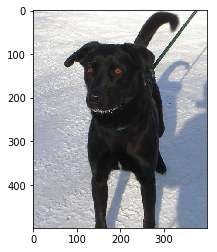

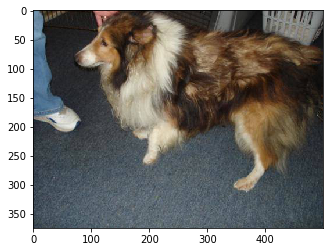

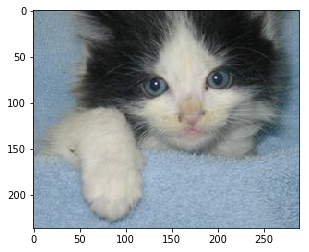

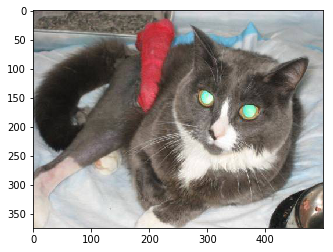

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import os

input_h = 150       # image height
input_w = 150       # image width
show_images = True

# --- paths ----
# train (cats):       /media/data/dogs_vs_cats_small/train/cats
# train (dogs):       /media/data/dogs_vs_cats_small/train/dogs
# validation (cats):  /media/data/dogs_vs_cats_small/validation/cats
# validation (dogs):  /media/data/dogs_vs_cats_small/validation/dogs
# test (cats):        /media/data/dogs_vs_cats_small/test/cats
# test (dogs):        /media/data/dogs_vs_cats_small/test/dogs

# --- display images (they are not preprocessed yet) ---
test_dir_cats = "/media/data/dogs_vs_cats_small/test/cats"
test_dir_dogs = "/media/data/dogs_vs_cats_small/test/dogs"

fnames_dogs = [os.path.join(test_dir_dogs, fname) for fname in os.listdir(test_dir_dogs)]
fnames_cats = [os.path.join(test_dir_cats, fname) for fname in os.listdir(test_dir_cats)]

if show_images:

    # convert PIL to np.array (cast to np.int in the range [0, 255])
    img_path = fnames_dogs[4]
    img = image.load_img(img_path)
    x = image.img_to_array(img).astype(int)
    plt.figure()
    plt.imshow(x)

    # convert PIL to np.array (as np.float32 in the range [0, 1])
    img_path = fnames_dogs[5]
    img = image.load_img(img_path)
    x = image.img_to_array(img) * 1./255
    plt.figure()
    plt.imshow(x)
    
    # convert PIL to np.array (cast to np.int in the range [0, 255])
    img_path = fnames_cats[4]
    img = image.load_img(img_path)
    x = image.img_to_array(img).astype(int)
    plt.figure()
    plt.imshow(x)

    # convert PIL to np.array (as np.float32 in the range [0, 1])
    img_path = fnames_cats[5]
    img = image.load_img(img_path)
    x = image.img_to_array(img) * 1./255
    plt.figure()
    plt.imshow(x)

    plt.show()

## Classify a single batch

In this section, we will perform these tasks:

1. Load the model.
2. Create a batch of 32 images of dogs and 32 of cats.
3. Classify the batches using the model.
4. Measure the accuracy (number of missclassified images) of the model regarding each class.


In [6]:
%matplotlib inline

def display_batch(batch, label="", limit=10):
    """
    Plots the images in the batch
    """
    
    for i, img in enumerate(batch):
        
        plt.figure()
        plt.imshow(img)
        title = "class: %s id: %d" % (label, i)
        plt.title(title)
        
        if (i+1) == limit:
            break

def create_batch(fnames):
    """
    Load images from a list of file paths.
    The images are preprocessed to match the shape and size expected by the model:
      - The images are rescaled in the range [0, 1]
      - The size is (150, 150)
    The output is a tensor of shape (n_samples, height, width, n_channels)
    """
    
    images = []
    
    for fname in fnames:
        
        # convert PIL to np.array (as np.float32 in the range [0, 1])
        img = image.load_img(fname,
                            color_mode="rgb",
                            target_size=(150, 150))
        x = image.img_to_array(img) * 1./255

        images.append(x)
        
    return np.array(images)
        


test_dir_cats = "/media/data/dogs_vs_cats_small/test/cats"
test_dir_dogs = "/media/data/dogs_vs_cats_small/test/dogs"

fnames_dogs = [os.path.join(test_dir_dogs, fname) for fname in os.listdir(test_dir_dogs)]
fnames_cats = [os.path.join(test_dir_cats, fname) for fname in os.listdir(test_dir_cats)]

# create the batch for dogs and cats
batch_dogs = create_batch(fnames_dogs[:32])
batch_cats = create_batch(fnames_cats[:32])

The next block displays a few samples of both batches:

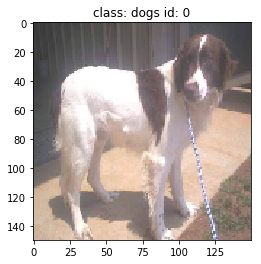

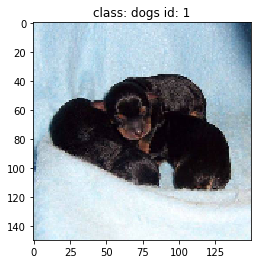

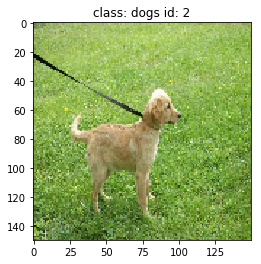

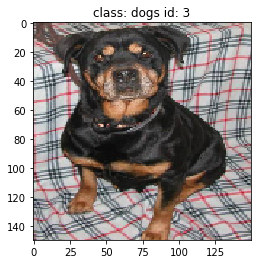

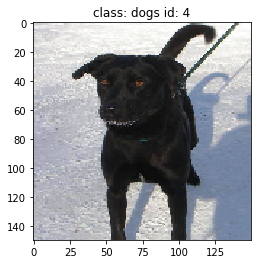

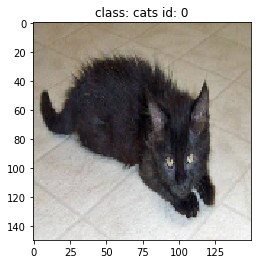

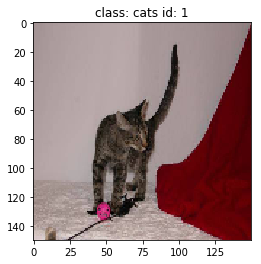

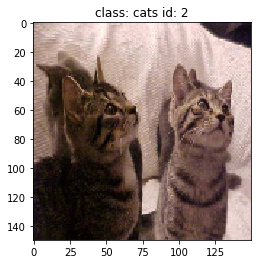

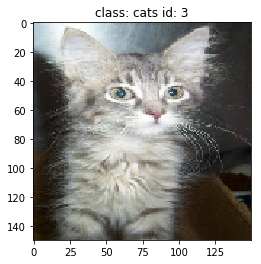

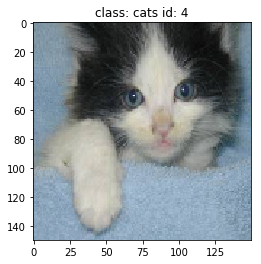

In [3]:
display_batch(batch_dogs, "dogs", limit=5)
display_batch(batch_cats, "cats", limit=5)

In [22]:
batch_dogs.shape

(32, 150, 150, 3)

Now that the batches are created, we can classify the images using the model previously trained. To this end, we use the `predict` function:

```
predict header and explanantion
```


-----

**Note** We trained the model using an instance of `ImageDataGenerator`.  That instance encondes the label names and ids according to the directory structure of the training images. In order to get the mapping back, we need to run the next block:

-----

In [7]:
# generator: it is only needed for getting the mapping of the class labels (from int id to str label)
train_datagen = ImageDataGenerator(rescale=1./255)      # rescale images by 1/255 
train_dir = "/media/data/dogs_vs_cats_small/train"
train_generator = train_datagen.flow_from_directory(train_dir,                          # path of images
                                                    target_size=(input_h, input_w),     # image size
                                                    batch_size=20,                      # number of images per batch
                                                    class_mode="binary"                 # because you use binary_crossentropy, you need binary labels
                                                    )
# mapping: {'cats': 0, 'dogs': 1}
class_indices = train_generator.class_indices

Found 2000 images belonging to 2 classes.


This is the mapping

In [8]:
class_indices

{'cats': 0, 'dogs': 1}

Keras provides several functions for prediction. Here, we review three of them:


```
predict(): Generates output predictions for the input samples. Returns Numpy array(s) of predictions.
```
[source](https://keras.io/models/sequential/)


```
predict_classes(): Generate class predictions for the input samples batch by batch. Returns an integer numpy array of class predictions.
predict_proba(): Generates class probability predictions for the input samples batch by batch. Returns a Numpy array of probability predictions.
```
[source](http://faroit.com/keras-docs/1.0.0/models/sequential/)


For some reason, the last two functions does not appear in the documentation of Keras 2.0 (I am using 2.2.5). However, they are still in the API. According to [this post](https://stackoverflow.com/questions/51382524/what-is-the-difference-between-predict-and-predict-class-functions-in-keras):

- `predict` is for regression problems (outputs are float values).
- `predict_classes` is for classification problems (outputs are int labels).


It turns out that both `predict_classes()` and `predict_proba()` rely in `predict()`. The code of these functions is located at:

```
/home/auraham/.virtualenvs/keras/lib/python3.5/site-packages/keras/engine/sequential.py
```

Here is the code:


```python
def predict_classes(self, x, batch_size=32, verbose=0):
    """Generate class predictions for the input samples.

    The input samples are processed batch by batch.

    # Arguments
        x: input data, as a Numpy array or list of Numpy arrays
            (if the model has multiple inputs).
        batch_size: integer.
        verbose: verbosity mode, 0 or 1.

    # Returns
        A numpy array of class predictions.
    """
    proba = self.predict(x, batch_size=batch_size, verbose=verbose)
    if proba.shape[-1] > 1:
        return proba.argmax(axis=-1)
    else:
        return (proba > 0.5).astype('int32')
```

As it can be seen, this function first calls `self.predict()` to get `proba` (the output of the network). The output is then processed according to its rank (i.e., number of dimensios):

- If the last dimension is greater than 1, the output (`proba`) encodes multiples classes.
- Otherwise, the output (`proba`) encondes two clases. 

For the first case, the probabilities are converted to integer labels as follows:

```
proba.argmax(axis=-1)
```

For the second case, the probabilities are converted to integer labels as follows (a very clever way to do it, IMO):

```
return (proba > 0.5).astype('int32')
```

Here, we are dealing with a binary-classification problem. So, we will use `predict_classes`. Just for completeness, here is the code of `predict_proba`:


```python
def predict_proba(self, x, batch_size=32, verbose=0):
    """Generates class probability predictions for the input samples.

    The input samples are processed batch by batch.

    # Arguments
        x: input data, as a Numpy array or list of Numpy arrays
            (if the model has multiple inputs).
        batch_size: integer.
        verbose: verbosity mode, 0 or 1.

    # Returns
        A Numpy array of probability predictions.
    """
    preds = self.predict(x, batch_size, verbose)
    if preds.min() < 0. or preds.max() > 1.: 
        warnings.warn('Network returning invalid probability values. '
                      'The last layer might not normalize predictions '
                      'into probabilities '
                      '(like softmax or sigmoid would).')
    return preds
```

As it can be seen, this function calls `self.predict()` to get the output of the model (`preds`). Then, it perform a sanity check.


In the following, we use `predict_classes` to predict the label of unseen images.

In [9]:
# load model
model = load_model("dogs_vs_cats_small_v1.h5")

# prediction
pred_dogs = model.predict(batch_dogs)
pred_cats = model.predict(batch_cats)

In [10]:
# cast to int
pred_dogs_classes = (pred_dogs > 0.5).astype("int32").flatten()
pred_cats_classes = (pred_cats > 0.5).astype("int32").flatten()

These are the predictions:

In [11]:
pred_dogs_classes

array([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0], dtype=int32)

In [12]:
pred_cats_classes

array([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0], dtype=int32)

and the missclassified samples:

In [13]:
class_indices

{'cats': 0, 'dogs': 1}

In [14]:
error_dogs = (pred_dogs_classes != class_indices["dogs"]).sum()
print("missclassified dogs", error_dogs)

missclassified dogs 11


In [15]:
error_cats = (pred_cats_classes != class_indices["cats"]).sum()
print("missclassified cats", error_cats)

missclassified cats 9


## Ignore from here

In [ ]:
model = load_model("dogs_vs_cats_small_v1.h5")

pred_dogs = model.predict(batch_dogs)




In [6]:
pred_dogs.argmax(axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
pred_dogs.shape

(32, 1)

In [7]:
import keras


pred_dogs = model.predict(batch_dogs)

#y_proba = model.predict(x)
y_proba = pred_dogs
y_classes = keras.np_utils.probas_to_classes(y_proba)


AttributeError: module 'keras' has no attribute 'np_utils'

In [ ]:
# --- load model ----
model = load_model("dogs_vs_cats_small_v1.h5")

# --- create data generator to preprocess input images ---
test_dir = "/media/data/dogs_vs_cats_small/test"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                target_size=(input_h, input_w),
                                                batch_size=32,
                                                class_mode="binary",
                                                shuffle=True,
                                                seed=42,
                                                )



# 1. did not work
"""
for batch in test_generator:

    pred = model.predict(batch)
    break
"""

# it works
#pred = model.predict(test_generator)

# it works
# get the first batch
for batch, labels in test_generator:

    # get predictions
    pred = model.predict(batch).flatten()

    # change prediction to int [0 or 1]
    pred_int = np.zeros_like(labels)
    to_keep = pred > 0.5

    # cast
    pred_int[to_keep]  = 1  # class 1
    pred_int[~to_keep] = 0  # class 0

    # missclassified examples
    error = (pred_int != labels).sum()
    n = len(labels)
    print("error: %d/%d" % (error, n))

    break

    



Now, we will classify a single batch using a generator.


```
flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest')
```
